GBDT系のハイパラ探索用

In [1]:
!pip install optuna catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
import os
os.chdir("/content/drive/MyDrive/projects/table_stan")
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.4 MB/s eta 0:00:00


In [28]:
from sklearn.model_selection import KFold, train_test_split

data = pd.read_csv("data/train.csv")
X_sub = pd.read_csv("data/test.csv")
df_sub = pd.DataFrame({"id":np.arange(len(X_sub))})

In [36]:
target = "cost"
random_state = 13
test_size = 0.1
n_splits = 5
num_boost_round = 1000
stopping_rounds = 50
n_trials = 100
drop_columns = ["cost"]
model_name = "LightGBM"

X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=test_size, random_state=random_state)
df_train = pd.DataFrame(pd.concat([X_train, y_train], axis=1), columns=data.columns)
df_test = pd.DataFrame(pd.concat([X_test, y_test], axis=1), columns=data.columns)

In [37]:
display(df_train.head())
display(df_test.head())

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
26554,8.50,5.0,3.0,1.0,3.0,11.20,1.0,0.0,28.0,23598.0,0.0,0.0,0.0,0.0,1.0,101.84
37713,1.80,3.0,1.0,0.0,2.0,19.90,1.0,0.0,24.0,23759.0,1.0,0.0,1.0,1.0,1.0,89.90
32430,7.28,4.0,4.0,0.0,1.0,12.50,1.0,0.0,34.0,23759.0,1.0,0.0,1.0,1.0,1.0,89.90
28301,4.26,3.0,3.0,3.0,3.0,7.31,1.0,1.0,8.0,33858.0,1.0,0.0,1.0,1.0,1.0,136.74
1611,3.33,3.0,5.0,0.0,1.0,17.30,1.0,1.0,6.0,21215.0,1.0,0.0,0.0,0.0,0.0,135.80


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
30798,5.13,3.0,3.0,2.0,3.0,20.90,0.0,1.0,23.0,21215.0,1.0,0.0,0.0,0.0,0.0,123.88
44160,4.44,3.0,2.0,2.0,2.0,14.00,0.0,0.0,34.0,23598.0,0.0,0.0,0.0,0.0,1.0,122.51
25844,8.73,3.0,2.0,0.0,2.0,21.80,1.0,0.0,10.0,30797.0,1.0,1.0,1.0,1.0,1.0,76.88
48597,8.88,3.0,5.0,2.0,2.0,9.96,0.0,1.0,32.0,30584.0,1.0,1.0,1.0,1.0,1.0,86.79
10109,6.39,3.0,5.0,1.0,3.0,17.00,0.0,0.0,35.0,30268.0,0.0,0.0,0.0,0.0,0.0,98.52


In [38]:
def lgbm_objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "random_state": random_state,
        "verbose": -1,
        "learning_rate": 0.1,
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 300), 
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "max_bin" : trial.suggest_int("max_bin", 32, 512),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0), 
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 10), 
        "feature_fraction":  trial.suggest_float("feature_fraction", 0.1, 1.0), 
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1e-6, 500, log=True)
    }
    score = []
    for train_index, val_index in cv.split(df_train):
      y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
      X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
      y_val = df_train.iloc[val_index][target].to_numpy()
      X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
      data_train = lgb.Dataset(X_train, y_train)
      data_val = lgb.Dataset(X_val, y_val)
      
      # モデルを訓練する
      evals_result = {}
      model = lgb.train(
          param,
          train_set=data_train,
          valid_sets=[data_train, data_val],
          num_boost_round=num_boost_round,
          callbacks=[
              lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=False),
              lgb.record_evaluation(evals_result),
          ],
      )
      y_pred = np.expm1(model.predict(X_val))
      score.append(mean_squared_error(y_val, y_pred, squared=False))
    return -np.mean(score)

objective_dict = {
    "LightGBM" : lgbm_objective
}

In [39]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

objective = objective_dict[model_name]
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_trial.params
best_score = study.best_trial.value

[I 2023-03-26 04:42:11,880] A new study created in memory with name: no-name-3a9a307d-6388-48ce-bef1-5641d86bb5cf
[I 2023-03-26 04:42:13,274] Trial 0 finished with value: -29.818927941767875 and parameters: {'max_depth': 3, 'num_leaves': 319, 'min_data_in_leaf': 20, 'min_gain_to_split': 1.4894182183782678, 'max_bin': 232, 'subsample': 0.5814864576069739, 'subsample_freq': 9, 'feature_fraction': 0.10374337645022313, 'reg_alpha': 0.0025583630598402557, 'reg_lambda': 0.0002193344693769917, 'scale_pos_weight': 5.886447382553852}. Best is trial 0 with value: -29.818927941767875.
[I 2023-03-26 04:42:14,062] Trial 1 finished with value: -30.028853964527684 and parameters: {'max_depth': 8, 'num_leaves': 446, 'min_data_in_leaf': 209, 'min_gain_to_split': 12.201214859925393, 'max_bin': 103, 'subsample': 0.8216278048966323, 'subsample_freq': 9, 'feature_fraction': 0.42024774664496467, 'reg_alpha': 0.002245865160310191, 'reg_lambda': 1.2975218893172374e-08, 'scale_pos_weight': 0.5860727336052645}.

In [40]:
lgbm_base_params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": random_state,
    "verbose": -1,
}

base_params_dict = {
    "LightGBM" : lgbm_base_params
}

base_params = base_params_dict[model_name]

params = {**base_params, **study.best_trial.params}
print(params)
print(best_score)

{'objective': 'regression', 'metric': 'rmse', 'random_state': 13, 'verbose': -1, 'max_depth': 6, 'num_leaves': 383, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.013188764853252405, 'max_bin': 211, 'subsample': 0.7971019224006646, 'subsample_freq': 9, 'feature_fraction': 0.24500368200493056, 'reg_alpha': 0.1299379716772481, 'reg_lambda': 0.19280890359297573, 'scale_pos_weight': 48.163619556844885}
-29.53049124819619


In [41]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
models = []
evals_results = []
FEATURES = df_train.drop(drop_columns, axis=1).columns.tolist()
df_importance = pd.DataFrame(index=FEATURES)
df_preds = df_sub[["id"]].copy()

scores = []

for i, (train_index, val_index) in enumerate(cv.split(df_train)):
  print("=" * 20, f"START FOLD {i+1}", "=" * 20)
  y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
  X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
  y_val = df_train.iloc[val_index][target].to_numpy()
  X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
    
  # モデルを訓練する
  if model_name=="LightGBM":
    data_train = lgb.Dataset(X_train, y_train)
    data_val = lgb.Dataset(X_val, y_val)
    evals_result = {}
    model = lgb.train(
        params, train_set=data_train, valid_sets=[data_train, data_val], num_boost_round=num_boost_round,
        callbacks=[
            lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
            lgb.record_evaluation(evals_result),
        ],
    )
    models.append(model)
    # 特徴量重要度
    df_importance[f"FOLD_{i+1}"] = model.feature_importance(
        importance_type="gain"
    )

  # 検証データ
  y_pred = np.expm1(model.predict(X_val))
  y_pred_clip = np.clip(y_pred, y_train.min(), y_train.max())
  rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
  scores.append(rmsle)
  
  # 提出用データ
  pred = np.expm1(model.predict(X_sub))
  df_preds[f"pred_{i+1}"] = pred

==================== START FOLD 1 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	training's rmse: 0.302743	valid_1's rmse: 99.6111
==================== START FOLD 2 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	training's rmse: 0.304045	valid_1's rmse: 99.7426
==================== START FOLD 3 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	training's rmse: 0.305318	valid_1's rmse: 98.7566
==================== START FOLD 4 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	training's rmse: 0.304656	valid_1's rmse: 99.6424
==================== START FOLD 5 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	training's rmse: 

In [42]:
print(f"Score mean: {np.mean(scores)}, Fold scores: {scores}")

Score mean: 0.30887671922154214, Fold scores: [0.30834797104521633, 0.3099608435254609, 0.3093463695481377, 0.30959604342248415, 0.3071323685664114]


In [43]:
df_preds[target] = df_preds.drop("id", axis=1).mean(axis=1)
print(df_train[target].min(), df_train[target].max())
print(df_preds[target].min(), df_preds[target].max())

50.79 149.75
73.78597534816149 121.67622498098403


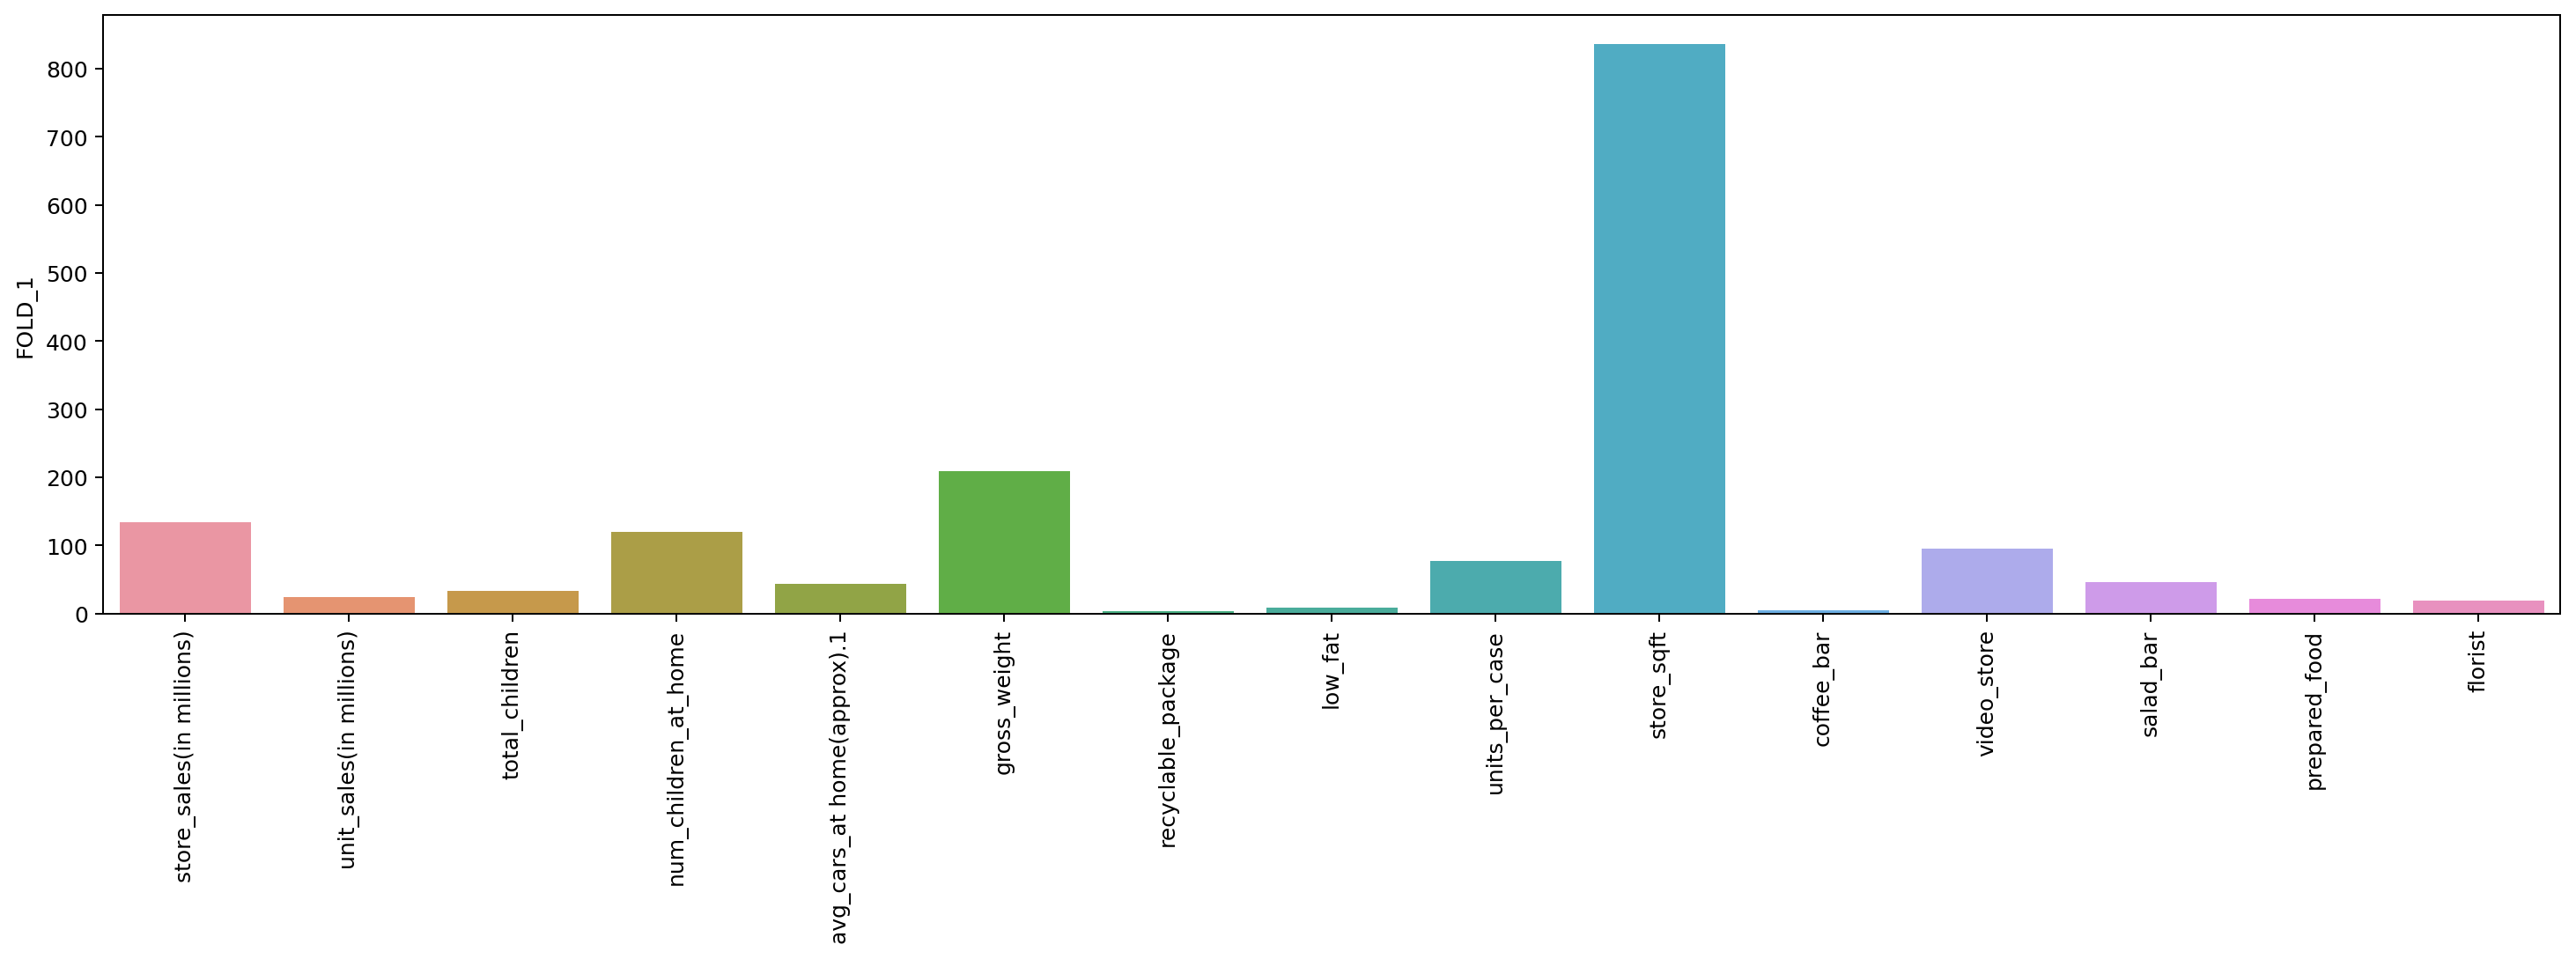

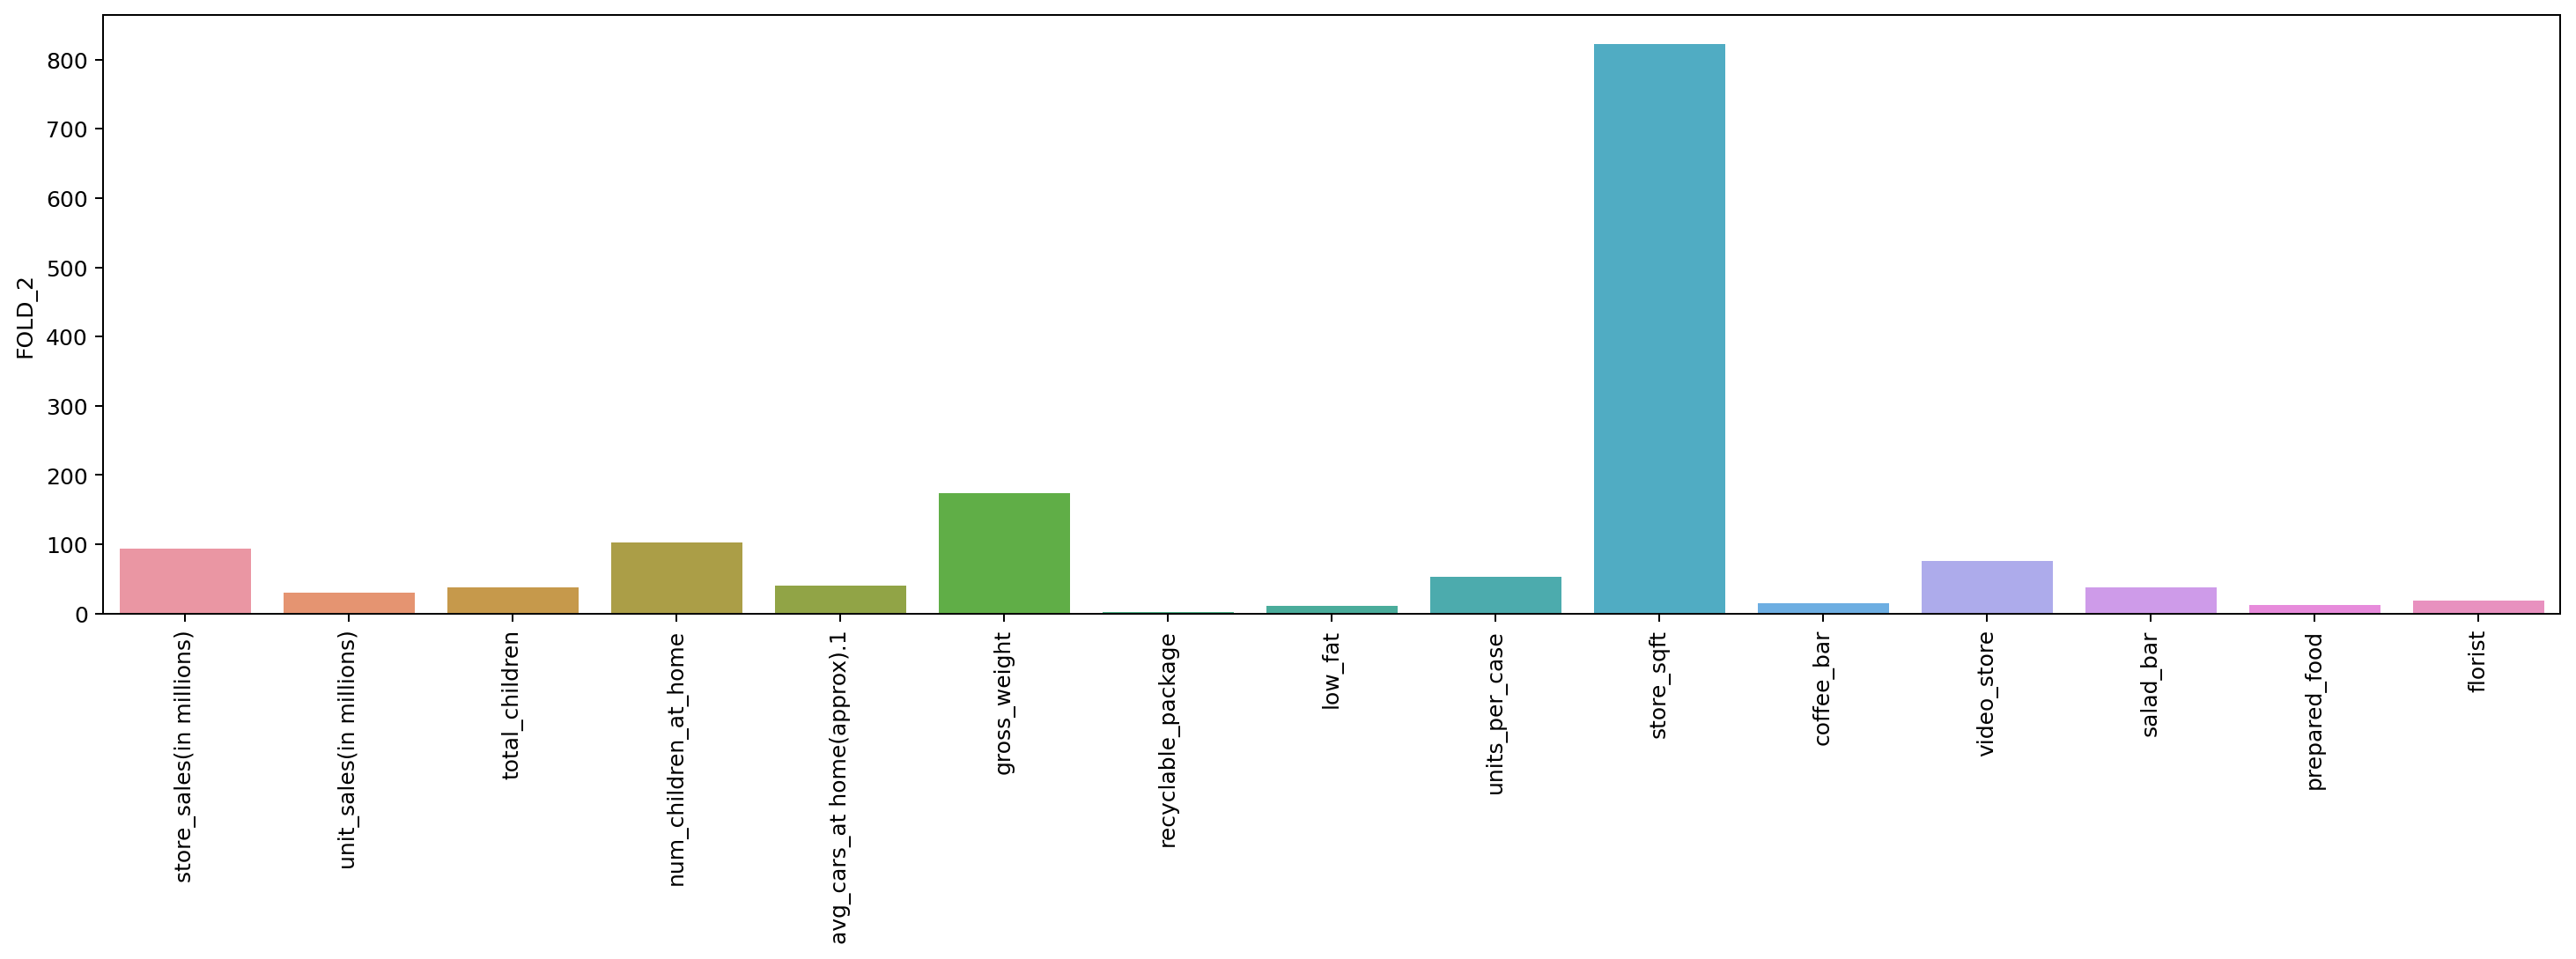

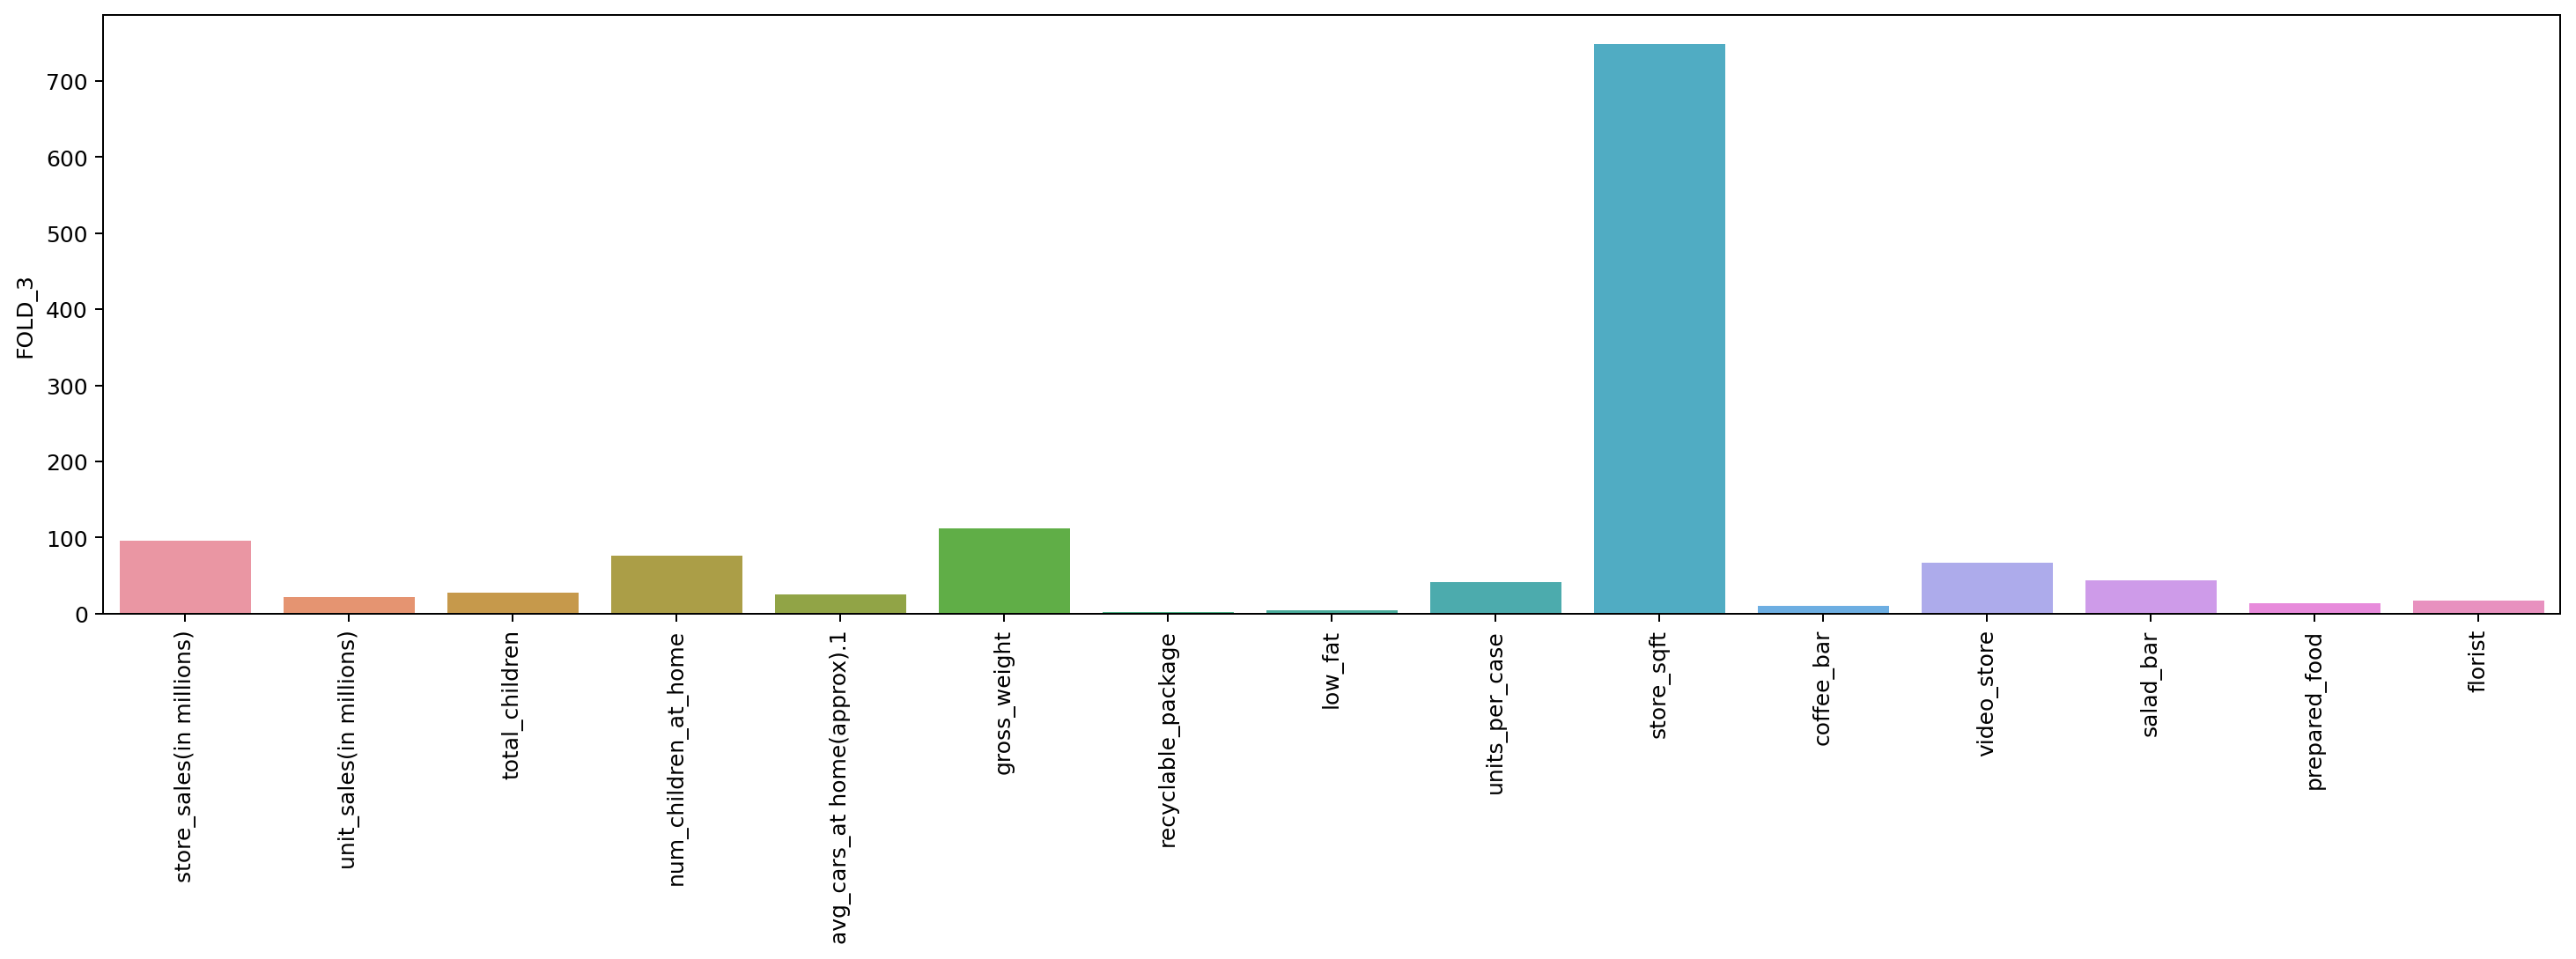

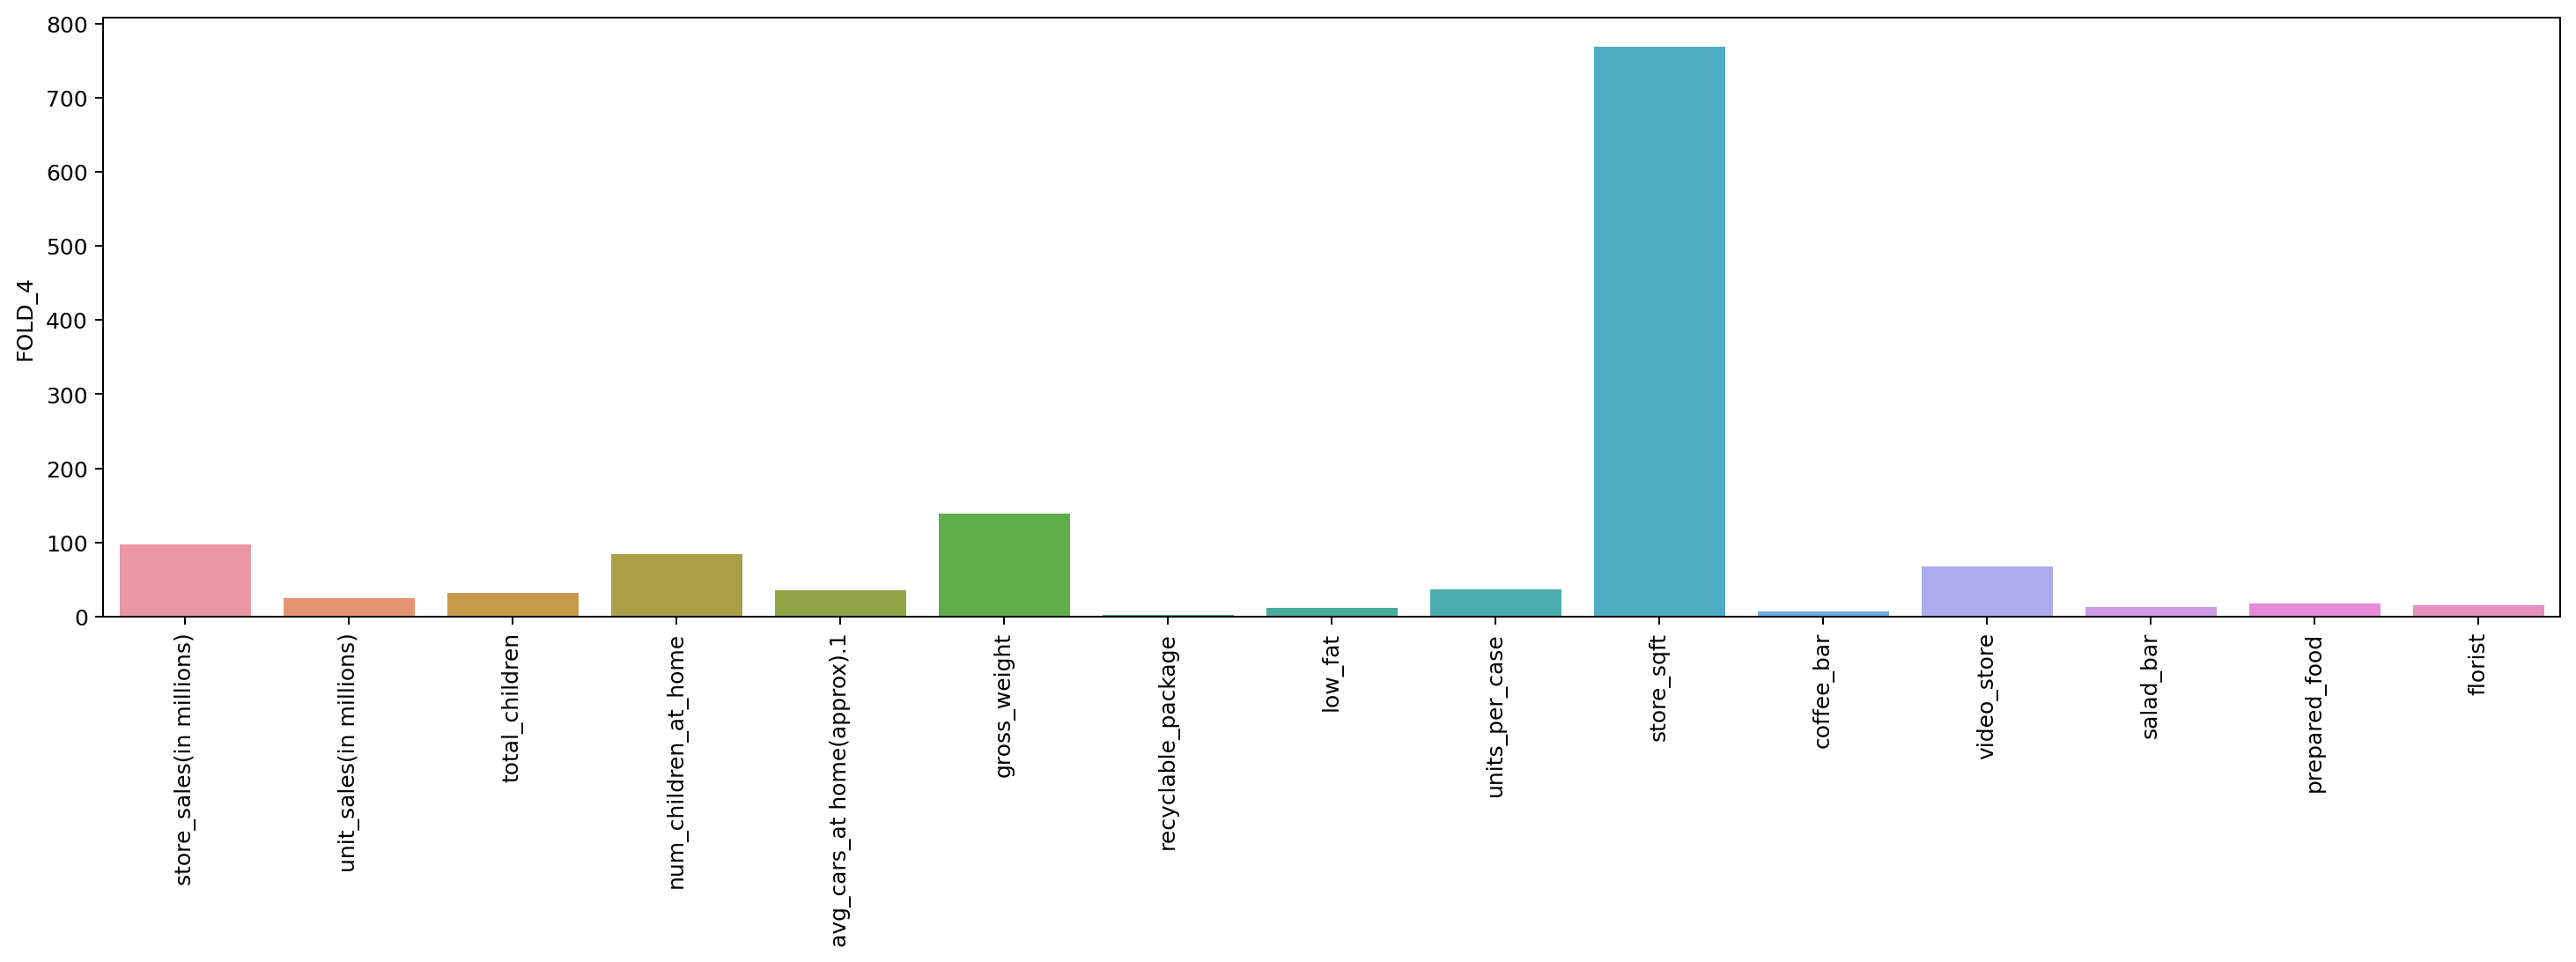

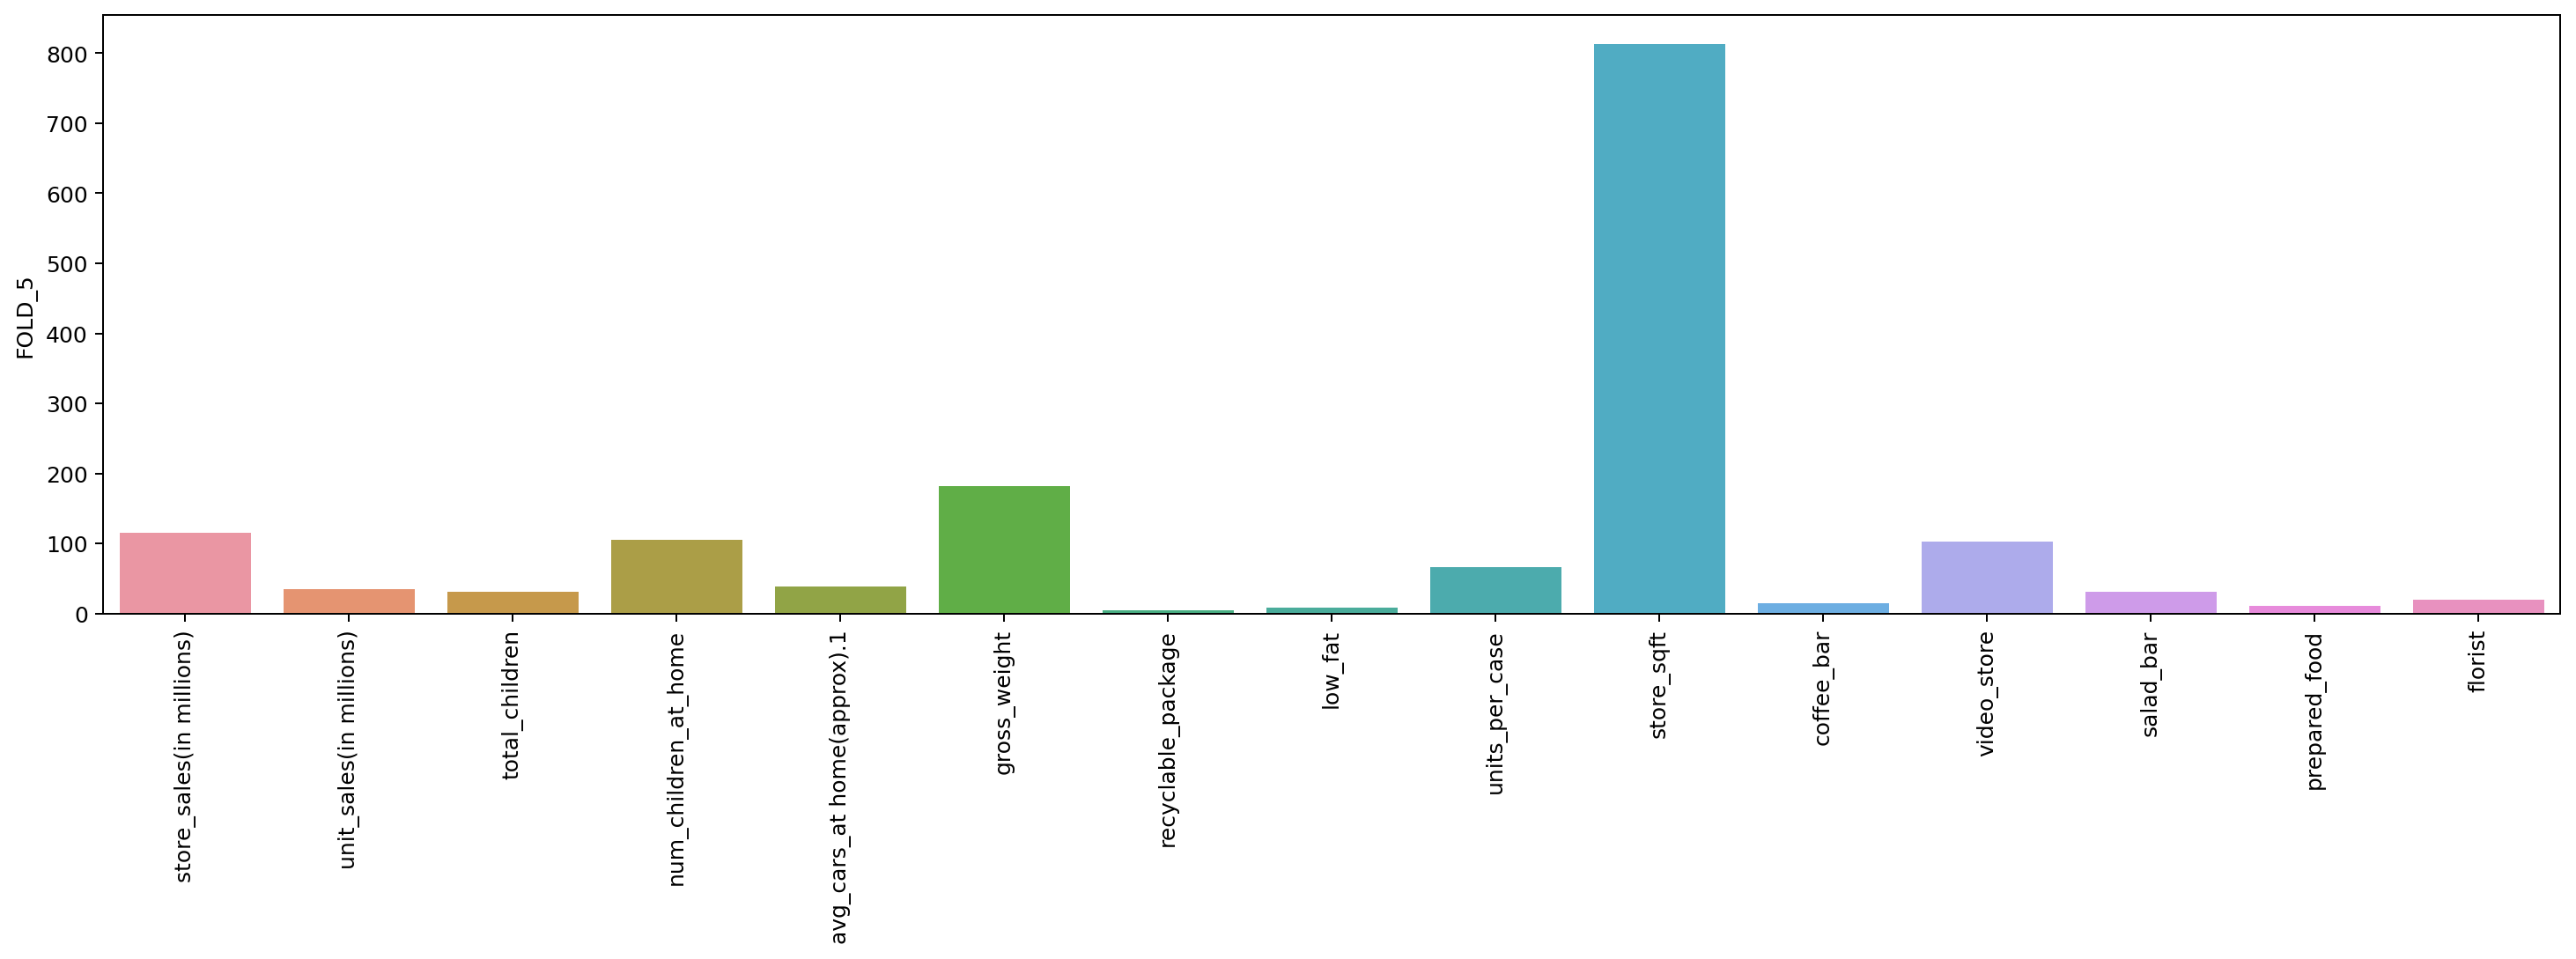

In [44]:
for col in df_importance.columns:
  fig = plt.figure(figsize=(20, 5), dpi=180)
  ax = fig.add_subplot(111)
  sns.barplot(x=df_importance.index, y=df_importance[col], ax=ax)
  plt.xticks(rotation=90)
  plt.show()

In [45]:
# now = datetime.now().astimezone(timezone('Asia/Tokyo'))

# submission = pd.read_csv("data/sample_submission.csv")
# submission["cost"] = df_preds["cost"].tolist()
# submission.to_csv(f"submissions/{now}-submission.csv", index=None)

In [46]:
# memo = ""

# pre = pd.read_csv("results/result.csv")
# df_result = pd.DataFrame([[now, "LightGBM", params, " ".join(FEATURES), np.mean(scores), , memo]])
# df_result.columns = ["date", "model", "params", "features", "val_RMSLE", "LB_RMSLE", "memo"]
# pd.concat([pre, df_result]).to_csv("results/result.csv", index=None)